<a href="https://colab.research.google.com/github/rajy4683/S15Test/blob/master/S15ResnetUnet_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri May 22 16:11:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys

Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive/EVA4/RekogNizer')
sys.path.append('/content/drive/My Drive/EVA4')
sys.path.append('/content/drive/My Drive/EVA4/DenseDepth')

### Dependencies


In [4]:
!pip install -r /content/drive/My\ Drive/EVA4/RekogNizer/requirements.txt

In [5]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-eux25u6x
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-eux25u6x
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=dab5ebf9038323889e23a399deb2740dfd4a3161568a200db9ed290a0c4a5eef
  Stored in directory: /tmp/pip-ephem-wheel-cache-5aa7rodk/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [0]:
import os

import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.color import label2rgb

import albumentations as A
import random
from google.colab.patches import cv2_imshow
from PIL import Image
import glob
import pandas as pd

import torch
from zipfile import ZipFile
import re
import h5py
import time



In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from RekogNizer import hyperparams

from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, MotionBlur
from albumentations import (
    HorizontalFlip, Compose, RandomCrop, Cutout,Normalize, HorizontalFlip, RandomBrightnessContrast,
    Resize,RandomSizedCrop, MotionBlur,MultiplicativeNoise,InvertImg, IAAFliplr,
	IAAPerspective,
)
from albumentations.pytorch import ToTensor
import random

from torchvision.datasets.vision import VisionDataset
from torchvision.datasets.utils import check_integrity, download_and_extract_archive
import os
import sys
import numpy as np
from torchvision import datasets
#from RekogNizer import imgnetloader
from RekogNizer import basemodelclass
from RekogNizer import mmdtraintest
from RekogNizer import mmddataloader
from RekogNizer import hyperparams
from RekogNizer import fileutils
from RekogNizer import mmdlosses
from RekogNizer import mmdmodels


from torch.utils.data import Dataset
import shutil
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, OneCycleLR, MultiStepLR, CyclicLR, ReduceLROnPlateau


import kornia

import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import wandb

  pip install torch-lr-finder -v --global-option="amp"
  pip install torch-lr-finder -v --global-option="amp"


In [8]:
!wandb login a6f947d2d2f69e7a8c8ca0f69811fd554f27d204
#tqdm._instances.clear()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
!rm -rf /content/train && mkdir -p /content/train
!rm -rf /content/test && mkdir -p /content/test

In [0]:
tqdm._instances.clear()

In [9]:
%%time
csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTrain.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
batch_start = 70000
batch_end = batch_start+10000
dest_dir="/content/train"

mmddataloader.extract_data_files_mt(csv_file, root_dir, batch_start,batch_end, dest_dir=dest_dir)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs


### Dataloader

In [10]:
%%time
size_hw = (56,56)
dest_dir="/content/train"
train_batch_size = 256
depth_dataset = mmddataloader.DepthMaskDataSet(csv_file, dest_dir, batch_start,batch_end, read_zip=False,
                                 transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 #transform_base=mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),#[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 #transform_bg=mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),#[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_opt=mmddataloader.flip,
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
train_loader = DataLoader(depth_dataset, batch_size=train_batch_size, shuffle=False, **kwargs)


CPU times: user 945 ms, sys: 115 ms, total: 1.06 s
Wall time: 1.13 s


In [0]:
test_csv_file ='/content/drive/My Drive/EVA4/tsai/S15EVA4/FinalDataSet/DepthMapDataSetTest.csv'
root_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/'
test_batch_start = 1000
test_batch_end = test_batch_start + 1000
test_batch_size=32
test_dest_dir = "/content/test"

#mmddataloader.extract_data_files(test_csv_file, root_dir, test_batch_start,test_batch_end, dest_dir=test_dest_dir)

In [0]:
size_hw = (56,56)
test_dest_dir = "/content/test"
test_dataset = mmddataloader.DepthMaskDataSet(test_csv_file, test_dest_dir, test_batch_start,test_batch_end,read_zip=False,
                                 #transform_base=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.56632738, 0.51567622, 0.45670792], [0.1076622, 0.10650349, 0.12808967] ),
                                 #transform_bg=mmddataloader.resize_bg(size_hw[0],size_hw[1],[0.57469445, 0.52241555, 0.45992244], [0.11322354, 0.11195428, 0.13441683]),
                                 transform_base = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_bg = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_mask = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 transform_depth = mmddataloader.resize_bg_nonNorm(size_hw[0],size_hw[1]),
                                 #transform_mask=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.0579508], [0.001662]),
                                 #transform_depth=mmddataloader.resize_bg(size_hw[0],size_hw[1], [0.3679109], [0.03551773]),
                                 )
from torch.utils.data import DataLoader
kwargs= { 'num_workers':4,'pin_memory': True}
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

In [0]:
from RekogNizer import mmdbetamodels



In [14]:
model_new = mmdmodels.ResNetUNet(2)
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")

summary(model_new.to(device), input_size=(6,56,56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           3,520
              ReLU-2           [-1, 64, 56, 56]               0
            Conv2d-3           [-1, 64, 56, 56]          36,928
              ReLU-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]             384
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
0.002818382931264454 0.5370317963702529 1.0912575721740723
{'lr': [0.0010715193052376064, 0.0011481536214968829, 0.0012302687708123817, 0.001318256738556407, 0.0014125375446227544, 0.0015135612484362083, 0.00162181009735893, 0.0017378008287493756, 0.0018620871366628676, 0.00199526231496888, 0.002137962089502232, 0.0022908676527677732, 0.0024547089156850307, 0.002630267991895382, 0.002818382931264454, 0.003019951720402016, 0.003235936569296283, 0.0034673685045253162, 0.0037153522909717258, 0.0039810717055349725, 0.004265795188015926, 0.00457088189614875, 0.004897788193684463, 0.0052480746024977255, 0.005623413251903491, 0.006025595860743578, 0.006456542290346557, 0.006918309709189366, 0.007413102413009174, 0.007943282347242814, 0.008511380382023764, 0.009120108393559099, 0.009772372209558108, 0.010471285480508997, 0.011220184543019632, 0.012022644346174128, 0.012882495516931339, 

  0%|          | 0/40 [3:36:48<?, ?it/s]


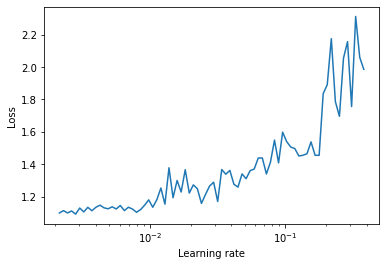

In [32]:
### LR finder ###
from RekogNizer import mmdtraintest
criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}
#model_new = mmdmodels.UNet(n_channels=6, n_classes=2)
optimizer=optim.SGD(model_new.parameters(), lr=0.001,momentum=0.9,  weight_decay=0)
lrfinder = mmdtraintest.find_lr_type1(model_new, optimizer, criterion, train_loader, testloader=None, seed=1, 
                                      start_lr=0.001, end_lr=1, step_mode="exp",num_iter=100)
min_lr = lrfinder.history['lr'][np.argmin(lrfinder.history['loss'])]
max_lr = np.max(lrfinder.history['lr'])
print(min_lr, max_lr, np.min(lrfinder.history['loss']))
print(lrfinder.history)
lrfinder.plot()
lrfinder.reset()


### Current Run

In [0]:
######## OCP 
from RekogNizer import mmdmodels
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")
#model_new.eval()

tqdm._instances.clear()
hyperparams.set_hyperparam({"epochs":10})

hyperparams.hyperparameter_defaults['run_name'] = fileutils.rand_run_name()
hyperparams.hyperparameter_defaults['epochs'] = 30
hyperparams.hyperparameter_defaults['lr'] = 0.002818382931264454 #0.03162277660168379
hyperparams.hyperparameter_defaults['ocp_max_lr'] = 0.002818382931264454 #0.03162277660168379

print("Initializing datasets and dataloaders")    

#model_new =  mmdmodels.UNet(n_channels=6, n_classes=2)
wandb_run_init = wandb.init(config=hyperparams.hyperparameter_defaults, 
                            project=hyperparams.hyperparameter_defaults['project'])
#wandb.watch_called = False
config = wandb.config
print(config)
#wandb.watch(model_new, log="none")

optimizer=optim.SGD(model_new.parameters(), lr=config.lr,momentum=config.momentum,
                        weight_decay=1e-5)

# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalBCELoss, mmdlosses.LocalPixelLoss], 
#            "depth":[mmdlosses.LocalRMSELoss, mmdlosses.LocalSSIMLoss]}
# criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalL1Loss], 
#            "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}

criterion={"mask":[mmdlosses.dice_loss, mmdlosses.LocalPixelLossL1], 
           "depth":[mmdlosses.LocalL1Loss, mmdlosses.LocalSSIMLoss]}

#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True, threshold=0.0001)
scheduler = OneCycleLR(optimizer, 
                        config.ocp_max_lr, 
                        epochs=config.epochs, 
                        cycle_momentum=False, 
                        steps_per_epoch=len(train_loader), 
                        base_momentum=config.momentum,
                        max_momentum=0.95, 
                        pct_start=0.2,
                        anneal_strategy=config.anneal_strategy,
                        div_factor=config.div_factor,
                        final_div_factor=config.final_div_factor
                           )

final_model_path = mmdtraintest.execute_model(model_new, 
            hyperparams.hyperparameter_defaults, 
            train_loader, test_loader, 
            device, 
            wandb=wandb,
            optimizer_in=optimizer,
            scheduler=scheduler,
            prev_saved_model=None,
            criterion=criterion,
            save_best=True,
            lars_mode=False,
            batch_step=True)

Initializing datasets and dataloaders


  0%|          | 0/40 [00:00<?, ?it/s]

wandb_version: 1

_wandb:
  desc: null
  value:
    cli_version: 0.8.36
    framework: torch
    is_jupyter_run: true
    is_kaggle_kernel: false
    python_version: 3.6.9
anneal_strategy:
  desc: null
  value: linear
batch_size:
  desc: null
  value: 512
bias:
  desc: null
  value: false
cycle_momentum:
  desc: null
  value: false
div_factor:
  desc: null
  value: 128
dropout:
  desc: null
  value: 0.1
epochs:
  desc: null
  value: 30
factor:
  desc: null
  value: 0.0
final_div_factor:
  desc: null
  value: 64
lr:
  desc: null
  value: 0.002818382931264454
lr_decay_threshold:
  desc: null
  value: 0.0
lr_policy:
  desc: null
  value: ocp
momentum:
  desc: null
  value: 0.9
no_cuda:
  desc: null
  value: false
ocp_max_lr:
  desc: null
  value: 0.002818382931264454
pct_start:
  desc: null
  value: 0.208
project:
  desc: null
  value: news5
run_name:
  desc: null
  value: 143f2b9087
sched_lr_gamma:
  desc: null
  value: 0.5
sched_lr_step:
  desc: null
  value: 1
seed:
  desc: null
  valu

loss=1.070040 m_loss=0.951919 d_loss=0.118121 batch_id=39: 100%|██████████| 40/40 [01:47<00:00,  2.68s/it]
loss=1.348544 m_loss=0.956722 d_loss=0.391821 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.06it/s]



Epoch: 1 Train set: Average loss: 1.098720, Mask loss:0.951669, Depth loss:0.147050, lr:0
Epoch: 1 Test set: Average loss: 1.350192, Mask loss:0.951786, Depth loss:0.398406
Model saved as Test loss reduced from  10000.0  to  1.350191593170166


loss=1.068420 m_loss=0.951816 d_loss=0.116604 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.348560 m_loss=0.956639 d_loss=0.391921 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.04it/s]



Epoch: 2 Train set: Average loss: 1.097822, Mask loss:0.951556, Depth loss:0.146266, lr:0
Epoch: 2 Test set: Average loss: 1.350179, Mask loss:0.951690, Depth loss:0.398489
Model saved as Test loss reduced from  1.350191593170166  to  1.3501787185668945


loss=1.066977 m_loss=0.951714 d_loss=0.115263 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.66s/it]
loss=1.348626 m_loss=0.956555 d_loss=0.392071 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.12it/s]



Epoch: 3 Train set: Average loss: 1.096959, Mask loss:0.951437, Depth loss:0.145522, lr:0
Epoch: 3 Test set: Average loss: 1.350116, Mask loss:0.951593, Depth loss:0.398523
Model saved as Test loss reduced from  1.3501787185668945  to  1.3501157760620117


loss=1.065641 m_loss=0.951612 d_loss=0.114029 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.348671 m_loss=0.956471 d_loss=0.392200 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.11it/s]



Epoch: 4 Train set: Average loss: 1.096173, Mask loss:0.951318, Depth loss:0.144854, lr:0
Epoch: 4 Test set: Average loss: 1.350029, Mask loss:0.951497, Depth loss:0.398532
Model saved as Test loss reduced from  1.3501157760620117  to  1.3500291109085083


loss=1.064419 m_loss=0.951511 d_loss=0.112908 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.348702 m_loss=0.956388 d_loss=0.392314 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.09it/s]



Epoch: 5 Train set: Average loss: 1.095452, Mask loss:0.951200, Depth loss:0.144252, lr:0
Epoch: 5 Test set: Average loss: 1.349926, Mask loss:0.951401, Depth loss:0.398525
Model saved as Test loss reduced from  1.3500291109085083  to  1.349926471710205


loss=1.063305 m_loss=0.951410 d_loss=0.111895 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.348725 m_loss=0.956305 d_loss=0.392420 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.23it/s]



Epoch: 6 Train set: Average loss: 1.094788, Mask loss:0.951082, Depth loss:0.143707, lr:0
Epoch: 6 Test set: Average loss: 1.349832, Mask loss:0.951305, Depth loss:0.398526
Model saved as Test loss reduced from  1.349926471710205  to  1.3498317003250122


loss=1.062268 m_loss=0.951310 d_loss=0.110958 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.66s/it]
loss=1.348741 m_loss=0.956222 d_loss=0.392519 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.17it/s]



Epoch: 7 Train set: Average loss: 1.094170, Mask loss:0.950963, Depth loss:0.143207, lr:0
Epoch: 7 Test set: Average loss: 1.349748, Mask loss:0.951210, Depth loss:0.398538
Model saved as Test loss reduced from  1.3498317003250122  to  1.3497477769851685


loss=1.061320 m_loss=0.951210 d_loss=0.110110 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.348727 m_loss=0.956139 d_loss=0.392588 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.34it/s]



Epoch: 8 Train set: Average loss: 1.093595, Mask loss:0.950846, Depth loss:0.142749, lr:0
Epoch: 8 Test set: Average loss: 1.349667, Mask loss:0.951114, Depth loss:0.398553
Model saved as Test loss reduced from  1.3497477769851685  to  1.3496671915054321


loss=1.060435 m_loss=0.951110 d_loss=0.109325 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.66s/it]
loss=1.348714 m_loss=0.956056 d_loss=0.392658 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.30it/s]



Epoch: 9 Train set: Average loss: 1.093057, Mask loss:0.950729, Depth loss:0.142329, lr:0
Epoch: 9 Test set: Average loss: 1.349587, Mask loss:0.951019, Depth loss:0.398568
Model saved as Test loss reduced from  1.3496671915054321  to  1.3495866060256958


loss=1.093900 m_loss=0.950763 d_loss=0.143137 batch_id=22:  55%|█████▌    | 22/40 [01:04<00:47,  2.62s/it]

### 1st Baseline: 
'/content/drive/My Drive/EVA4/model_saves/model-270f3c5ce8.h5'

#### No improvement in Masks so next step is to introduce Pixel Loss
```
Epoch: 28 Train set: Average loss: 1.092363, Mask loss:0.954360, Depth loss:0.138004, lr:0
Epoch: 28 Test set: Average loss: 1.353533, Mask loss:0.954385, Depth loss:0.399148
loss=1.055960 m_loss=0.954910 d_loss=0.101050 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.66s/it]
loss=1.352928 m_loss=0.958979 d_loss=0.393948 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.02it/s]
  0%|          | 0/40 [00:00<?, ?it/s]
Epoch: 29 Train set: Average loss: 1.092217, Mask loss:0.954354, Depth loss:0.137863, lr:0
Epoch: 29 Test set: Average loss: 1.353553, Mask loss:0.954380, Depth loss:0.399173
loss=1.055725 m_loss=0.954907 d_loss=0.100817 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]
loss=1.352963 m_loss=0.958981 d_loss=0.393982 batch_id=31: 100%|██████████| 32/32 [00:05<00:00,  6.00it/s]

Epoch: 30 Train set: Average loss: 1.092082, Mask loss:0.954353, Depth loss:0.137729, lr:0
Epoch: 30 Test set: Average loss: 1.353575, Mask loss:0.954381, Depth loss:0.399194
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-16a26cd1e5.h5  best loss: 1.3528698682785034
```

```

1.111
'/content/drive/My Drive/EVA4/model_saves/model-34aa565470.h5',
```

```
Epoch: 28 Train set: Average loss: 1.106478, Mask loss:0.958703, Depth loss:0.147775, lr:0
Epoch: 28 Test set: Average loss: 1.149450, Mask loss:0.962841, Depth loss:0.186609
loss=1.080171 m_loss=0.956438 d_loss=0.123732 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.65s/it]
loss=1.141316 m_loss=0.961596 d_loss=0.179720 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.69it/s]
  0%|          | 0/40 [00:00<?, ?it/s]
Epoch: 29 Train set: Average loss: 1.104515, Mask loss:0.956433, Depth loss:0.148082, lr:0
Epoch: 29 Test set: Average loss: 1.148193, Mask loss:0.956916, Depth loss:0.191277
loss=1.104760 m_loss=0.962930 d_loss=0.141829 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.65s/it]
loss=1.122331 m_loss=0.965649 d_loss=0.156681 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.77it/s]

Epoch: 30 Train set: Average loss: 1.112334, Mask loss:0.958333, Depth loss:0.154001, lr:0
Epoch: 30 Test set: Average loss: 1.135881, Mask loss:0.960620, Depth loss:0.175261
Model saved as Test loss reduced from  1.1377310752868652  to  1.1358811855316162
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-1123c1f907.h5  best loss: 1.1358811855316162
```
```
Epoch: 28 Train set: Average loss: 1.132197, Mask loss:0.954871, Depth loss:0.177326, lr:0
Epoch: 28 Test set: Average loss: 1.145516, Mask loss:0.955028, Depth loss:0.190488
Model saved as Test loss reduced from  1.1456940174102783  to  1.1455156803131104
loss=1.099055 m_loss=0.955430 d_loss=0.143625 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.65s/it]
loss=1.130585 m_loss=0.959614 d_loss=0.170972 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.62it/s]

Epoch: 29 Train set: Average loss: 1.131893, Mask loss:0.954857, Depth loss:0.177036, lr:0
Epoch: 29 Test set: Average loss: 1.145339, Mask loss:0.955013, Depth loss:0.190326
Model saved as Test loss reduced from  1.1455156803131104  to  1.1453393697738647
loss=1.098524 m_loss=0.955416 d_loss=0.143108 batch_id=39: 100%|██████████| 40/40 [01:45<00:00,  2.65s/it]
loss=1.130429 m_loss=0.959599 d_loss=0.170830 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.59it/s]

Epoch: 30 Train set: Average loss: 1.131592, Mask loss:0.954843, Depth loss:0.176749, lr:0
Epoch: 30 Test set: Average loss: 1.145165, Mask loss:0.954999, Depth loss:0.190166
Model saved as Test loss reduced from  1.1453393697738647  to  1.145164966583252
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-6020a4d373.h5  best loss: 1.145164966583252
```

```
Epoch: 28 Train set: Average loss: 1.142827, Mask loss:0.955357, Depth loss:0.187470, lr:0
Epoch: 28 Test set: Average loss: 1.151757, Mask loss:0.955537, Depth loss:0.196220
Model saved as Test loss reduced from  1.1520137786865234  to  1.151757001876831
loss=1.123311 m_loss=0.955928 d_loss=0.167383 batch_id=39: 100%|██████████| 40/40 [01:45<00:00,  2.64s/it]
loss=1.135275 m_loss=0.960127 d_loss=0.175148 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.66it/s]

Epoch: 29 Train set: Average loss: 1.142404, Mask loss:0.955337, Depth loss:0.187067, lr:0
Epoch: 29 Test set: Average loss: 1.151503, Mask loss:0.955517, Depth loss:0.195986
Model saved as Test loss reduced from  1.151757001876831  to  1.151503086090088
loss=1.122012 m_loss=0.955908 d_loss=0.166105 batch_id=39: 100%|██████████| 40/40 [01:46<00:00,  2.65s/it]
loss=1.135071 m_loss=0.960107 d_loss=0.174964 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.45it/s]

Epoch: 30 Train set: Average loss: 1.141987, Mask loss:0.955318, Depth loss:0.186669, lr:0
Epoch: 30 Test set: Average loss: 1.151255, Mask loss:0.955497, Depth loss:0.195758
Model saved as Test loss reduced from  1.151503086090088  to  1.151254653930664
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-2a2029b950.h5  best loss: 1.151254653930664
```


```
Model saved as Test loss reduced from  1.1617459058761597  to  1.1608949899673462
loss=1.140195 m_loss=0.955044 d_loss=0.185151 batch_id=78: 100%|██████████| 79/79 [02:09<00:00,  1.64s/it]
loss=1.139409 m_loss=0.960868 d_loss=0.178542 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]

Epoch: 30 Train set: Average loss: 1.156679, Mask loss:0.956014, Depth loss:0.200665, lr:0
Epoch: 30 Test set: Average loss: 1.160079, Mask loss:0.956235, Depth loss:0.203844
Model saved as Test loss reduced from  1.1608949899673462  to  1.1600786447525024
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-1e2e3a0f7b.h5  best loss: 1.1600786447525024
```

```
Epoch: 19 Train set: Average loss: 1.225193, Mask loss:0.959097, Depth loss:0.266096, lr:0
Epoch: 19 Test set: Average loss: 1.220985, Mask loss:0.959358, Depth loss:0.261628
Model saved as Test loss reduced from  1.2267167568206787  to  1.2209854125976562
loss=1.224883 m_loss=0.957894 d_loss=0.266989 batch_id=78: 100%|██████████| 79/79 [02:09<00:00,  1.64s/it]
loss=1.191264 m_loss=0.963844 d_loss=0.227420 batch_id=31: 100%|██████████| 32/32 [00:04<00:00,  6.92it/s]

Epoch: 20 Train set: Average loss: 1.219652, Mask loss:0.958924, Depth loss:0.260728, lr:0
Epoch: 20 Test set: Average loss: 1.215931, Mask loss:0.959185, Depth loss:0.256746
Model saved as Test loss reduced from  1.2209854125976562  to  1.2159314155578613
Final model save path: /content/drive/My Drive/EVA4/model_saves/model-270f3c5ce8.h5  best loss: 1.2159314155578613
```


## Inferencing

In [0]:
del model_new,expand_model
torch.cuda.empty_cache()

In [0]:
#mmdmodels.UNet(n_channels=6, n_classes=2)

#model_new = mmdmodels.UNet(2)
model_new = mmdmodels.ResNetUNet(2)
device = torch.device("cuda" if not hyperparams.hyperparameter_defaults['no_cuda'] else "cpu")

model_new = mmdtraintest.load_model_for_infer(model_new, 
                                  '/content/drive/My Drive/EVA4/model_saves/model-16a26cd1e5.h5',
                                  device)

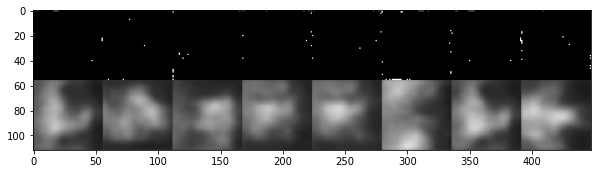

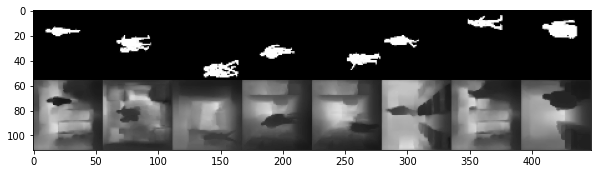

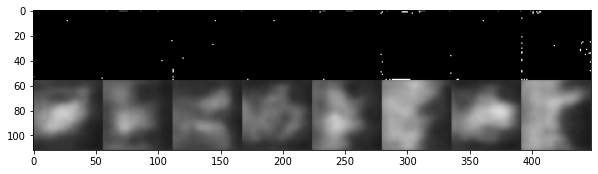

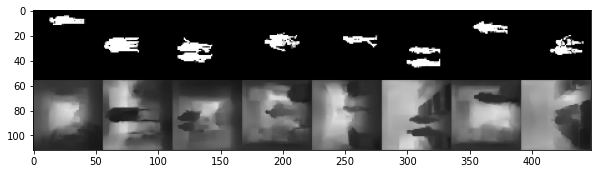

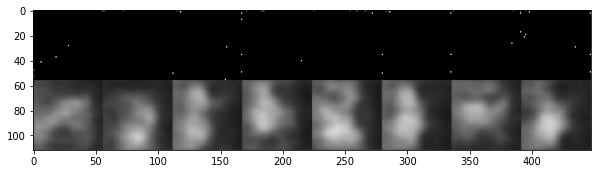

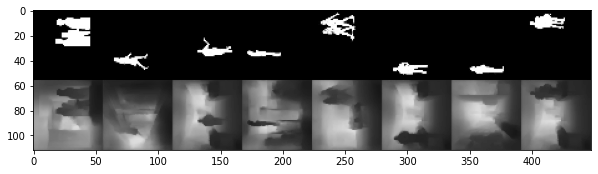

In [31]:
mmdtraintest.display_samples_new(model_new, test_loader, device)

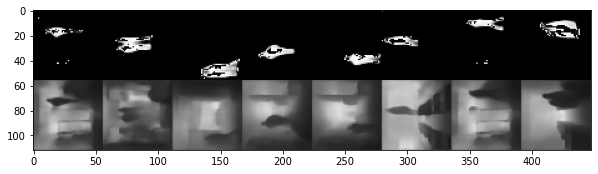

In [0]:
img = iter(test_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]

mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

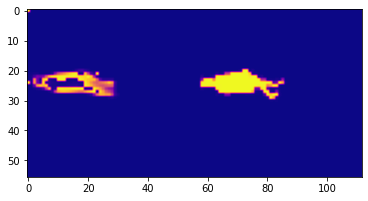

In [0]:
offset=5
plt.imshow(np.hstack([mask_pred[offset],mask_gt[offset]*255]), cmap='plasma')

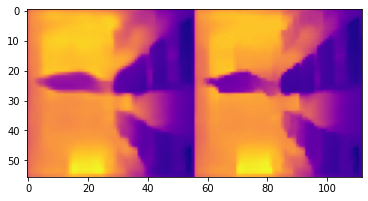

In [0]:
plt.imshow(np.hstack([depth_pred[offset],depth_gt[offset]*255]), cmap='plasma')

### RMSE + L1 + Dice + BCE

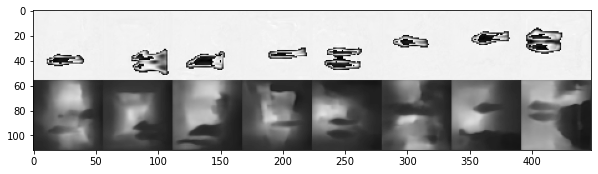

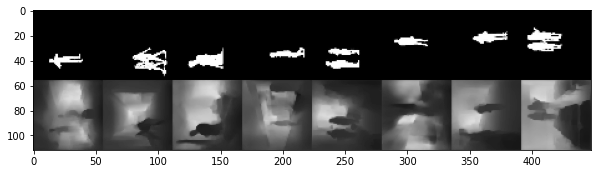

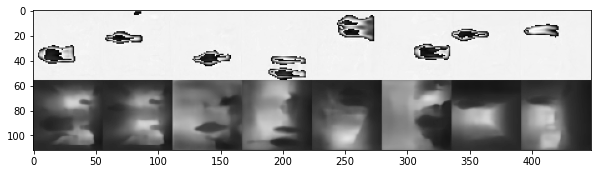

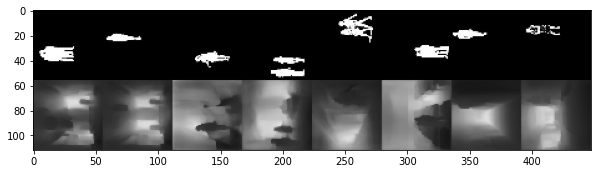

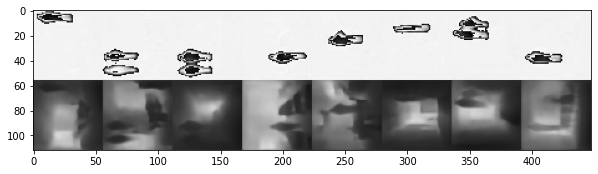

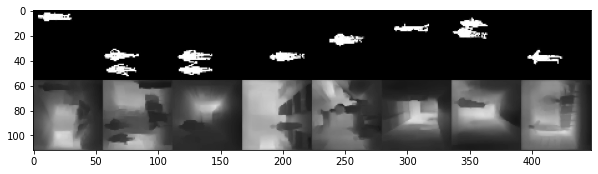

In [0]:
mmdtraintest.display_samples(model_new, train_loader, device)

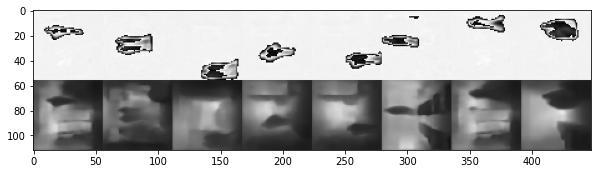

In [0]:
img = iter(test_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]

# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]

#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

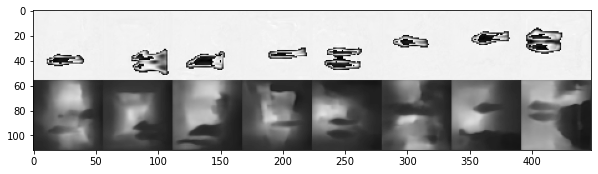

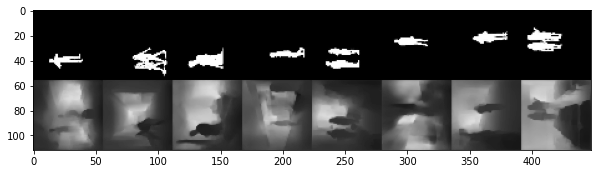

In [0]:
img = iter(train_loader).next()
with torch.no_grad():
    output_val = model_new(img['input'].to(device)).to("cpu")
output_pred = torch.split(output_val,1,dim=1)
mask_pred = [kornia.tensor_to_image((output_pred[0][val].to("cpu")*255).byte()) for val in range(8) ]
depth_pred = [kornia.tensor_to_image((output_pred[1][val].to("cpu")*255).byte()) for val in range(8) ]

# mask_pred = [kornia.tensor_to_image(((output_pred[0][val].to("cpu")*0.0016620444341229432+0.057950844077600344)*255).byte()) for val in range(8) ]
# depth_pred = [kornia.tensor_to_image(((output_pred[1][val].to("cpu")*0.03551773442719045+0.3679109312239146)*255).byte()) for val in range(8) ]


img_shape = img['output'][0][1].shape[1]
mask_gt = [img['output'][0][val].reshape(img_shape,img_shape) for val in range(8) ]
depth_gt = [img['output'][1][val].reshape(img_shape,img_shape) for val in range(8) ]

#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

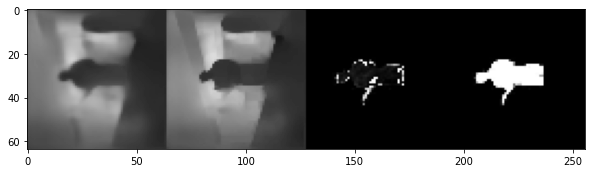

In [0]:
offset=4
plt.figure(figsize=(10,10)) 

plt.imshow(np.hstack([depth_pred[offset],
                      depth_gt[offset]*255,
                      mask_pred[offset]*mask_gt[offset].numpy(),
                      mask_gt[offset]*255]),cmap='gray')


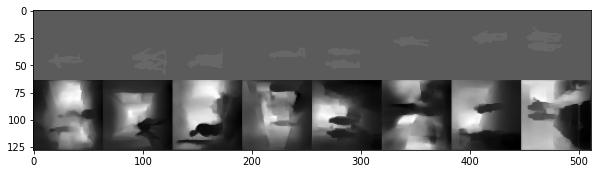

In [0]:
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_gt),np.hstack(depth_gt)]),cmap='gray')

## Dice with RMSE

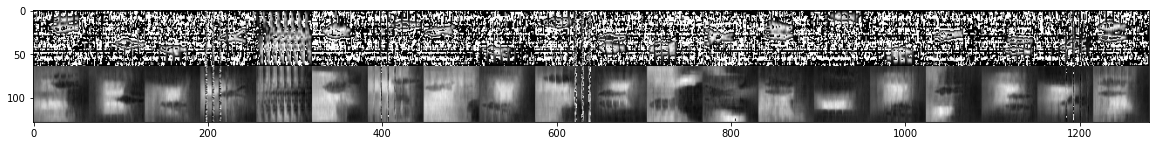

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(20,20)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

In [0]:
offset = 5
plt.imshow(np.hstack([img['output'][1][offset].reshape(64,64),
                      depth_pred[offset]]),cmap='gray')

                    #   img['output'][0][offset].reshape(64,64),
                    #   mask_pred[offset]]),
                    #  cmap='gray')

In [0]:
plt.imshow(img['output'][0][offset].reshape(64,64),cmap='gray')

### BCE with SSIM Epoch = 10, Train = 20,000 Test=512

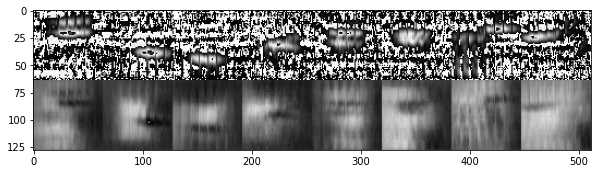

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## Small batch RMSE

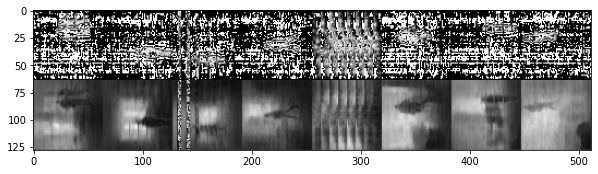

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.vstack([np.hstack(mask_pred),np.hstack(depth_pred)]),cmap='gray')

## BaseLine Predictions with plain RMSE

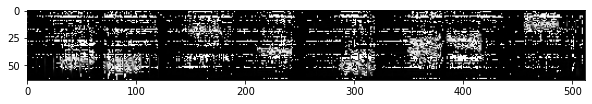

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(mask_pred),cmap='gray')

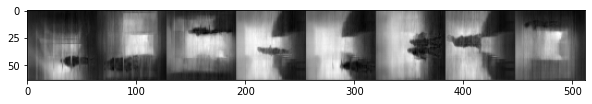

In [0]:
#Image.fromarray(kornia.tensor_to_image((mask_pred*255).byte())),
plt.figure(figsize=(10,10)) 
plt.imshow(np.hstack(depth_pred),cmap='gray')

In [0]:
!pip install kornia

     |████████████████████████████████| 163kB 6.0MB/s 


In [0]:
np.concatenate((img['input'][0][0].numpy(),img['input'][0][1].numpy()), axis=2).shape

(250, 250, 6)

In [0]:
 
pbar = tqdm(depth_dataset)

#bg_mean = np.zeros((4,3))
n, mean, M2 = (0.0,0.0,0.0)
for i_batch,img in enumerate(pbar):
    #img = depth_dataset[i_batch]
    #img_mean = np.mean(img, axis=(0,1))
    img_mean = np.array([ np.mean(iter_val/255.0,axis=(0,1)) for left_k,right_v in img.items() for iter_val in right_v ])
    n, mean, M2 = update_mean_variance((n, mean, M2), img_mean)

print(finalize_mean_variance(n, mean, M2))

In [0]:
# hf = h5py.File('data7.h5', 'w')
# #base_zip = ZipFile('/content/image_mask_gt2k6k.zip')
# #pbar = tqdm(depth_dataset)
# #hf.close()
# def hf_create_dataset(hdf_file, file_name, data):
#     hdf_file.create_dataset(
#                 name=file_name,
#                 data=data,
#                 compression="gzip", compression_opts=9
#                 )
# i_batch=0
# #for i_batch,img in enumerate(pbar):
# start = time.process_time()
# #try:
# for img in depth_dataset:
#     #key_name = 
#     if(i_batch > 100000):
#         break
#     #val_arr = [iter_val 
#     for left_k,right_v in img.items():
#         for inner_k, iter_val in right_v.items():
#             #print(inner_k)
#             hf_create_dataset(hf, inner_k ,iter_val)

#     if(i_batch % 1000 == 0 and i_batch > 1000):
#         current = time.process_time()
#         print("No:of records processed:{} Time Elapsed:{}".format(i_batch, current-start))
#     i_batch += 1

# end = time.process_time()
# print("No:of records processed:{} Time Elapsed:{}".format(i_batch, end-start))
# #except:

# #    hf.close()

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

In [0]:
import uuid
bucket_name = 'colab-sample-bucket-' + str(uuid.uuid1())

body = {
  'name': bucket_name,
  # For a full list of locations, see:
  # https://cloud.google.com/storage/docs/bucket-locations
  'location': 'us',
}
gcs_service.buckets().insert(project=project_id, body=body).execute()
print('Done')

In [0]:
hf.close()

In [0]:
hf_read = h5py.File('data7.h5', 'r')

In [0]:
hf_read.keys()

<KeysViewHDF5 ['depth_image_023aa22186_classroom_1.jpg', 'depth_image_0ccf0b6adb_classroom_8.jpg', 'depth_image_0d06379c4e_classroom_12.jpg', 'depth_image_100078863e_classroom_10.jpg', 'depth_image_1000d68e48_classroom_2.jpg', 'depth_image_10023ed777_classroom_12.jpg', 'depth_image_10027aa3fa_classroom_4.jpg', 'depth_image_1002953763_classroom_1.jpg', 'depth_image_1002a448f4_classroom_10.jpg', 'depth_image_1002be3508_classroom_3.jpg', 'depth_image_1002e52563_classroom_14.jpg', 'depth_image_1002e75f62_classroom_15.jpg', 'depth_image_100317e99d_classroom_14.jpg', 'depth_image_1003212d72_classroom_8.jpg', 'depth_image_10033c4a69_classroom_8.jpg', 'depth_image_10038181d7_classroom_3.jpg', 'depth_image_1003ffcca2_classroom_10.jpg', 'depth_image_1004993b2d_classroom_13.jpg', 'depth_image_1004dd5dd3_classroom_16.jpg', 'depth_image_100659c8dd_classroom_17.jpg', 'depth_image_1006609a43_classroom_16.jpg', 'depth_image_10074a3520_classroom_8.jpg', 'depth_image_1007f75489_classroom_8.jpg', 'depth_

In [0]:
### Knuth/Welford algorithm to generate mean by addition of new samples to existing mean

def update_mean_variance(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2

    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize_mean_variance(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float('nan')
    else:
       (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
       return (mean, variance, sampleVariance)

In [0]:
calc_mean,variance, _ = finalize_mean_variance((n, mean, M2))
print(calc_mean)
print(np.sqrt(variance))

[[0.56632738 0.51567622 0.45670792]
 [0.57469445 0.52241555 0.45992244]
 [0.05795104 0.05795104 0.05795104]
 [0.61635181 0.21432114 0.50569604]]
[[0.1076622  0.10650349 0.12808967]
 [0.11322354 0.11195428 0.13441683]
 [0.02640032 0.02640032 0.02640032]
 [0.09193359 0.07619106 0.04919082]]


In [0]:
#depth_map = np.hstack([depth_dataset[index_val]['output'][1] for index_val in myrandom_array])
depth_map = [depth_dataset[index_val]['output'][1] for index_val in myrandom_array]
mask_image = [depth_dataset[index_val]['output'][0] for index_val in myrandom_array]
bg_image = [depth_dataset[index_val]['input'][1] for index_val in myrandom_array]
fg_bg_image = [depth_dataset[index_val]['input'][0] for index_val in myrandom_array]
final_list = np.hstack([ mask_image, bg_image, fg_bg_image])

In [0]:
from matplotlib import pyplot as plt

In [0]:
plt.figure(figsize=(24,32))
plt.imshow(depth_map,cmap='gray')

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, depth_map):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
plt.savefig('/content/drive/My Drive/EVA4/tsai/S15EVA4/depthmaptile.png')

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(100., 100.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 20),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_list):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

In [0]:
Image.fromarray(depth_dataset[0]['output'][0])

In [0]:
Image.fromarray(depth_dataset[0]['output'][1])

In [0]:
import glob
fileList = [file_name for file_name in glob.glob('/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/*png')]
print("Number of images of people:{}".format(len(fileList)))

Number of images of people:110


In [0]:
import os

for file_name in fileList:
    image_name = os.path.basename(file_name)
    my_array = np.array(Image.open(file_name))
    print("FileName: {} Shape:{}".format(image_name, my_array.shape))

In [0]:
base_dir = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/'
aug_path = '/content/drive/My Drive/EVA4/tsai/S15EVA4/people_cropresize/aug_images'
image_list = [ ]


for file_name in glob.glob(base_dir+"/*png")[:20]:
    basefile_name = os.path.basename(file_name)
    #print(basefile_name)
    mask_name = os.path.join(aug_path,"mask_"+basefile_name)
    flip_name = os.path.join(aug_path,"flip_"+basefile_name)
    flip_mask_name = os.path.join(aug_path,"mask_"+os.path.basename(flip_name))
    print(file_name,mask_name,flip_name,  flip_mask_name)
    image_list.append([np.array(Image.open(val)) for val in [file_name,mask_name,flip_name,  flip_mask_name ]])

In [0]:
for val in image_list:
    plt.imshow(np.hstack([val[0],val[2]]))
    plt.imshow(np.hstack([val[1],val[3]]))

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
#for iter in image_list:
for ax, im in zip(grid, image_list[2]):
    #print(ax., )
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap='gray')

In [0]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [0]:
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [0]:
model.summary()